In [1]:

# Setting up google drive 
'''
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive', force_remount=True)\nimport sys\nsys.path.append('/content/gdrive/MyDrive/Colab Notebooks')\n"

In [1]:

import torch
from torch import nn
import collections
from collections import defaultdict
from IPython import display
import math
from matplotlib import pyplot as plt
import os
import pandas as pd
import random
import re
import sys
from zmq import device
d2l = sys.modules[__name__]

import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [3]:
# All funtions in this cell used from my_utils package provided during labs with some modifications


def get_dataloader_workers():  
    """Use 4 processes to read the data."""
    return 4

def use_svg_display(): 
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')
    

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    #axes.yaxis.set_major_locator(MultipleLocator(0.05))
    #axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if legend:
        axes.legend(legend)
    axes.grid()

    

def load_data_cifar10(batch_size, resize=None,rotation1=None,crop=None):  
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize)) # Resizes the image to given size
    if rotation1:
        trans.insert(0, transforms.RandomRotation(rotation1)) # rotates the image to a given angle
    if crop:
        trans.append(transforms.RandomResizedCrop(crop, scale=(0.8,1.0))) # Crops image will have an area between 80% and 100% of the area of the original image and resizes it to given size
    
    trans.append(transforms.RandomHorizontalFlip()) #Flips image horizontally
    #trans.append(transforms.RandomVerticalFlip()) # Flips image vertically
    trans.append(transforms.ColorJitter()) # Randomly change the brightness, contrast, saturation and hue of an image or video.
    
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)  
    mnist_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))




def accuracy(y_hat, y, device=None): 
    """Compute the number of correct predictions."""
    
    if device:
        y_hat = y_hat.to(device)
        y = y.to(device)
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # If y_hat is a matrix
        y_hat = d2l.argmax(y_hat, axis=1)       # choose the highest value from each row
    cmp = d2l.astype(y_hat, y.dtype) == y       # Compare with true label
    
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))   # Number of correctly predicted labels



def evaluate_accuracy(net, data_iter):  
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]



class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]



def train_epoch_ch3(net, train_iter, loss, updater,device): 
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y),
                       y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5, 5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts


    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)



def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater,device): 
    """Train a model (defined in Chapter 3)."""
    net.to(device)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1.5],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater,device)  # Calculate train matrics
        test_acc = evaluate_accuracy_gpu(net, test_iter,device)  # Calculate test accuracy
        animator.add(epoch + 1, train_metrics + (test_acc,))  # Plot results
        
    train_loss, train_acc = train_metrics
    print("Train metric: ",train_metrics)
    print("Test metric: ",test_acc)
    
    assert train_loss < 0.5, train_loss       # If train_loss < 0.5 then error
    # Train and test accuracy should be greater than 70% and less than 100
    assert train_acc <= 1 and train_acc > 0.7, train_acc  
    assert test_acc <= 1 and test_acc > 0.7, test_acc

    

def evaluate_accuracy_gpu(net, data_iter, device=None): 
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]


# Aliases
tensor = torch.tensor

numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)

# Read training and test data

In [4]:
# Read training and test data
batch_size = 180
train_iter, test_iter = load_data_cifar10(batch_size,rotation1=10)
type(train_iter)

Files already downloaded and verified
Files already downloaded and verified


torch.utils.data.dataloader.DataLoader

In [5]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu


Using device: cuda
NVIDIA A40


In [6]:
# Check data
data = torch.from_numpy(train_iter.dataset.data)
label = train_iter.dataset.classes 
print(label) #5000 images 32x32 pixels for each image and 3 channels 
print(data.shape) #[ All images [Image [ Row [ Pixel ]]]]

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([50000, 32, 32, 3])


# Defining the Model

In [12]:
class block(torch.nn.Module):
    
    def __init__(self, num_inputs_ch, num_outputs):
        super(block, self).__init__()
        self.num_inputs = num_inputs_ch  # Num of input channels
        self.num_outputs = num_outputs   # Number of output channels
       
        self.spatialavgpool = nn.AvgPool2d(kernel_size=4,stride=2,padding = 2)
        self.Fltn = nn.Flatten()
        self.linear1 = nn.LazyLinear(256)  # A Linear module where in_features is inferred.
        self.linear2 = nn.LazyLinear(128)
        self.linear3 = nn.LazyLinear(4)
        self.g = nn.Sigmoid()
        
        self.Convl1 = nn.Conv2d(self.num_inputs, self.num_outputs, 3,stride=1,padding=1,dilation=1)
        self.bn1 = nn.BatchNorm2d(self.num_outputs, momentum=0.9)
        self.max1 = nn.MaxPool2d(2,stride=2)
        
        self.Convl2 = nn.Conv2d(self.num_inputs, self.num_outputs, 3,stride=1,padding=1,dilation=1)
        self.bn2 = nn.BatchNorm2d(self.num_outputs, momentum=0.9)
        self.max2 =nn.MaxPool2d(2,stride=2)
        
        self.Convl3 = nn.Conv2d(self.num_inputs, self.num_outputs, 3,stride=1,padding=1,dilation=1)
        self.bn3 = nn.BatchNorm2d(self.num_outputs, momentum=0.9)
        self.max3 = nn.MaxPool2d(2,stride=2)
        
        self.Convl4 = nn.Conv2d(self.num_inputs, self.num_outputs, 4,stride=1,padding=2,dilation=1)
        self.bn4 = nn.BatchNorm2d(self.num_outputs, momentum=0.9)
        self.max4 =nn.MaxPool2d(2,stride=2)

        self.relu = nn.LeakyReLU()
      
    def forward(self, x):
        x = x.to(device) # Put X on device
        sap = self.spatialavgpool(x) # Spatial Average Pool
        outflat = self.Fltn(sap)  
       
        outlinear = self.linear1(outflat)  #L1
        outlinear = self.relu(outlinear)   
        outlinear = self.linear2(outlinear) #L2
        outlinear = self.relu(outlinear)
        outlinear = self.linear3(outlinear) #L3
        a = self.g(outlinear)   # Final non-linear sigmoid activation
        
        # C1
        o1 = self.Convl1(x)
        o1 = self.relu(o1)
        o1 = self.bn1(o1)   # Batch normalisation
        o1 = self.max1(o1)  # Max pool layer
        
        # C2
        o2 = self.Convl2(x)  
        o2 = self.relu(o2)
        o2 = self.bn2(o2)
        o2 = self.max2(o2)
        
        # C3
        o3 = self.Convl3(x)
        o3 = self.relu(o3)
        o3 = self.bn3(o3)
        o3 = self.max3(o3)
        
        # C4
        o4 = self.Convl4(x)
        o4 = self.relu(o4)
        o4 = self.bn4(o4)
        o4 = self.max4(o4)
        
 
        
        '''
        print("a:",a.shape)
        print("conv1:",o1.shape)
        print("conv2:",o2.shape)
        print("conv3:",o3.shape)
        print("conv4:",o4.shape)
        #print("a*o:",o.shape)
        '''
        # Reshape elements of vector 'a'
        a1 = a[:,0].view(x.shape[0], 1, 1, 1)
        a2 = a[:,1].view(x.shape[0], 1, 1, 1)
        a3 = a[:,2].view(x.shape[0], 1, 1, 1)
        a4 = a[:,3].view(x.shape[0], 1, 1, 1)

        
        
        # Sum of multiplication of ak with ok
        o = torch.mul(a1,o1)+torch.mul(a2,o2)+torch.mul(a3,o3)+torch.mul(a4,o4)

        return o

In [13]:
class cifar(torch.nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super(cifar, self).__init__()
        self.num_inputs = num_inputs  # Number of input channels
        self.num_outputs = num_outputs # Number of outputs (not channels)
        
        self.b1 = block(self.num_inputs, 64)
        self.b2 = block(64,125)
        self.b3 = block(125,256)
        self.b4 = block(256,384)

        self.spatialavgpool = nn.AvgPool2d(kernel_size=4,stride=2,padding = 1)
        self.Fltn = nn.Flatten()
        
        self.linear1 = nn.LazyLinear(512)
        self.linear2 = nn.LazyLinear(256)
        self.linear3 = nn.LazyLinear(self.num_outputs)
        
        self.r = nn.LeakyReLU()
        self.g =  nn.Sigmoid()
        
        
    def forward(self, x):
        # Block 1
        f1 = self.b1(x)
        f1 = self.r(f1)
        
        # Block 2
        f2 = self.b2(f1)
        f2 = self.r(f2)
        
        # Block 3
        f3 = self.b3(f2)
        f3 = self.r(f3)
        
        # Block 4
        f4 = self.b4(f3)
        
        # Classifier
        f6 = self.spatialavgpool(f4)  # Spatial avg pool taking inout from last block
        oflat = self.Fltn(f6)
        
        olinear = self.linear1(oflat)  #L1
        olinear = self.g(olinear)
        olinear = self.linear2(olinear)  #L2
        olinear = self.g(olinear)
        O = self.linear3(olinear)   #L3
        
        return O


In [14]:
# Initialize weights
def init_weights(m):
    if type(m)==nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)      

model = cifar(3, 10) # 3 input channel and 10 outputs. 1 for each class
# Apply weights to model
model.apply(init_weights);
print(model)

cifar(
  (b1): block(
    (spatialavgpool): AvgPool2d(kernel_size=4, stride=2, padding=2)
    (Fltn): Flatten(start_dim=1, end_dim=-1)
    (linear1): LazyLinear(in_features=0, out_features=256, bias=True)
    (linear2): LazyLinear(in_features=0, out_features=128, bias=True)
    (linear3): LazyLinear(in_features=0, out_features=4, bias=True)
    (g): Sigmoid()
    (Convl1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Convl2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Convl3): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentu

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Loss and Optimization Algorithm
* As in Softmax Regression

In [15]:
loss = nn.CrossEntropyLoss()
lr = 0.1 # Learning rate
mom = 0.9  #momentum

#wd = 0.0001 # weight decay

# optimiser used SGD
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom) 

Train metric:  (0.02870798313478008, 0.98974)
Test metric:  0.8568


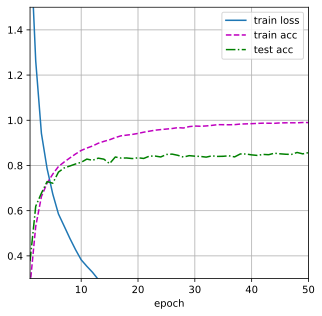

In [9]:
num_epochs = 50

train_ch3(model, train_iter, test_iter, loss, num_epochs, optimizer, device)